In [3]:
from pyMez.Code.DataHandlers.Translations import *
from pyMez.Code.DataHandlers.GraphModels import *

In [103]:
# getting around to adding a breadth first graph solver to Graph class
# modify the find_path method
class Graph(object):
    """The Graph class creates a content graph that has as nodes different formats. As
    a format is added via graph.add_node() by specifying a node name and a function from an
    existing node into the new one, and one exiting the node. Once a series of nodes exists
    to enter the graph at a node use graph.set_state() the current data representing the
    state is in the attribute graph.data. To move among the formats use graph.move_to_node('NodeName')
    need to recode the find_path method using a shortest path alogrithm like
    [Dijkstra](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).
    """
    def __init__(self,**options):
        """Initializes the graph. The first 2 nodes and two edges forming a bijection between them are required"""
        defaults={"graph_name":"Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["A plain string",
                                       "A list of strings with no \\n, created with string.splitlines()"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":"This is a test string\n it has to have multiple lines \n and many characters 34%6\n^",
                  "edge_2_to_1":edge_2_to_1,
                  "edge_1_to_2":edge_1_to_2
                 }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        self.elements=['graph_name','node_names','node_descriptions','current_node','state','data']
        for element in self.elements:
            self.__dict__[element]=self.options[element]
        self.edges=[]
        self.edge_matrices=[]
        self.state_matrix=np.matrix(self.state).T
        # Add the first 2 edges, required to intialize the graph properly
        self.display_graph=networkx.DiGraph()

        self.add_edge(self.node_names[0],self.node_names[1],self.options["edge_1_to_2"])
        self.add_edge(self.node_names[1],self.node_names[0],self.options["edge_2_to_1"])
        self.jumps=[]
        self.external_node_names=[]
        self.external_node_descriptions=[]
        self.display_layout=networkx.spring_layout(self.display_graph)

    def get_description_dictionary(self):
        "returns a dictionary of the form {NodeName:Node Description for all of the current nodes"
        dictionary={node_name:self.node_descriptions[index] for index,node_name in enumerate(self.node_names)}
        return dictionary

    def set_state(self,node_name,node_data):
        """Sets the graph state to be the state specified by node_name, and node_data"""
        try:
            current_node_state_position=self.node_names.index(node_name)
            self.current_node=node_name
            self.data=node_data
            self.state=[0 for i in range(len(self.node_names))]
            self.state[current_node_state_position]=1
            self.state_matrix=np.matrix(self.state).T
        except:
            print("Could not set the state of graph: {0}".format(self.graph_name))
            raise

    def add_edge(self,begin_node=None,end_node=None,edge_function=None):
        """Adds an edge mapping one node to another, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        edge_match=re.compile("edge_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(edge_match,key):
                iterator+=1
        edge_name="edge_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[edge_name]=edge_function
        self.edges.append(edge_name)
        edge_matrix=np.zeros((len(self.state),len(self.state)))
        begin_position=self.node_names.index(begin_node)
        end_position=self.node_names.index(end_node)
        edge_matrix[end_position][begin_position]=1
        edge_matrix=np.matrix(edge_matrix)
        self.edge_matrices.append(edge_matrix)
        self.display_graph.add_edge(begin_node,end_node)
        self.display_layout=networkx.spring_layout(self.display_graph)

    def add_jump(self,begin_node=None,end_node=None,jump_function=None):
        """Adds a jump mapping one internal node to an external node, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        jump_match=re.compile("jump_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(jump_match,key):
                iterator+=1
        jump_name="jump_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[jump_name]=jump_function
        self.jumps.append(jump_name)
        self.display_graph.add_edge(begin_node,end_node)
        self.display_layout=networkx.spring_layout(self.display_graph)
        
    def move_to(self,path,**options):
        """Changes the state of the graph by moving along the path specified"""
        defaults={"debug":False,"verbose":False}
        move_options={}
        for key,value in defaults.iteritems():
            move_options[key]=value
        for key,value in options.iteritems():
            move_options[key]=value
        
        if move_options["debug"]:
                        print(path)
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            if move_options["verbose"]:
                print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            self.data=self.__dict__[edge](self.data)
            #print self.data
            self.current_node=match.groupdict()['end_node']
            self.state=[0 for i in range(len(self.node_names))]
            position=self.node_names.index(self.current_node)
            self.state[position]=1
            self.state_matrix=np.matrix(self.state).T
            #print self.state
            #print self.current_node

    def virtual_move_to(self,path):
        """virtual_move_to simulates moving but does not change the state of the graph"""
        #print path
        temp_state=self.state
        temp_data=self.data
        temp_current_node=self.current_node
        temp_node_names=self.node_names
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            #print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            temp_data=self.__dict__[edge](temp_data)
            #print self.data
            temp_current_node=match.groupdict()['end_node']
            temp_state=[0 for i in range(len(temp_node_names))]
            position=temp_node_names.index(temp_current_node)
            temp_state[position]=1
            #print temp_state
            #print self.state
            #print self.current_node

    def __str__(self):
        return str(self.data)

    def add_node(self,node_name,edge_into_node_begin,edge_into_node_function,edge_out_node_end,
                 edge_out_node_function,node_description=None):
        """Adds a node to the graph. Required input is node_name (a string with no spaces),
        a reference to an entering node,the function mapping the entering node to the new node,
        a reference to an exiting node and the function mapping the
        new node to the exiting node."""
        # first check if node into and out of node is good
        self.node_names.append(node_name)
        self.state.append(0)
        self.state_matrix=np.matrix(self.state).T
        for index,matrix in enumerate(self.edge_matrices):
            pad_row=np.zeros((1,len(matrix)))
            new_matrix=np.concatenate((matrix, pad_row), axis=0)
            pad_column=np.zeros((1,len(self.node_names)))
            new_matrix=np.concatenate((new_matrix, pad_column.T), axis=1)
            #print("New matrix is :\n{0}".format(new_matrix))
            self.edge_matrices[index]=new_matrix
        self.add_edge(begin_node=node_name,end_node=edge_out_node_end,edge_function=edge_out_node_function)
        self.add_edge(begin_node=edge_into_node_begin,end_node=node_name,edge_function=edge_into_node_function)
        if node_description:
            self.node_descriptions.append(node_description)
        self.display_graph.add_node(node_name)
        self.display_graph.add_edge(node_name,edge_out_node_end)
        self.display_graph.add_edge(edge_into_node_begin,node_name)
        self.display_layout=networkx.spring_layout(self.display_graph)

    def add_external_node(self,external_node_name,jump_into_node_begin,
                          jump_into_node_function,external_node_description=None):
        """Adds an external node to the graph. Required input is node_name (a string with no spaces),
        a reference to an entering node,the function mapping the entering node to the new external node"""
        # first check if node into and out of node is good
        self.external_node_names.append(external_node_name)
        self.add_jump(begin_node=jump_into_node_begin,end_node=external_node_name,jump_function=jump_into_node_function)
        if external_node_description:
            self.external_node_descriptions.append(external_node_description)
        self.display_graph.add_node(external_node_name)
        self.display_graph.add_edge(jump_into_node_begin,external_node_name)
        self.display_layout=networkx.spring_layout(self.display_graph)

    def jump_to_external_node(self,external_node_name,**options):
        """Returns the result of the jump, the graph is left in the node that is the begining of the jump"""
        end_node=external_node_name
        jump_pattern='jump_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(end_node)
        for jump in self.jumps[:]:
            jump_match=re.match(jump_pattern,jump,re.IGNORECASE)
            if jump_match:
                jump_to_use=jump
                begin_node=jump_match.groupdict()["begin_node"]

        self.move_to_node(begin_node)
        return self.__dict__[jump_to_use](self.data,**options)



    def path_length(self,path,num_repeats=10):
        """Determines the length of a given path, currently the metric is based on the time to move to."""
        begin_time=datetime.datetime.now()
        #num_repeats=100
        for i in range(num_repeats):
            self.virtual_move_to(path)
        end_time=datetime.datetime.now()
        delta_t=end_time-begin_time
        path_length=delta_t.total_seconds()/float(num_repeats)
        if path_length ==0.0:
            print("Warning the path length is less than 1 microsecond,"
                  "make sure num_repeats is high enough to measure it.")
        return path_length

    def is_path_valid(self,path):
        """Returns True if the path is valid from the current node position or False otherwise"""
        null_state=[0 for i in range(len(self.node_names))]
        null_state_matrix=np.matrix(null_state).T
        new_state=np.matrix(self.state).T
        for index,edge in enumerate(path):
            #print index
            #print edge
            edge_position=self.edges.index(edge)
            move_matrix=self.edge_matrices[edge_position]
            #print move_matrix
            new_state=move_matrix*new_state
            if new_state.any()==null_state_matrix.any():
                #print new_state
                #print null_state_matrix
                return False
        return True


    def get_entering_nodes(self,node):
        """Returns all nodes that have an edge that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_nodes=[]
        for index,edge in enumerate(self.edges):
            enter_match=re.match(enter_edge_pattern,edge)
            if enter_match:
                enter_node=enter_match.groupdict()['begin_node']
                enter_nodes.append(enter_node)
        return enter_nodes

    def get_entering_edges(self,node):
        """Returns all edges that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(enter_edge_pattern,edge):
                enter_edges.append(edge)
        return enter_edges

    def get_exiting_edges(self,node):
        """Returns all edges that exit the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(exit_edge_pattern,edge):
                exit_edges.append(edge)
        return exit_edges

    def get_exiting_nodes(self,node):
        """Returns all nodes that have an edge leaving the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_nodes=[]
        for index,edge in enumerate(self.edges):
            exit_match=re.match(exit_edge_pattern,edge)
            if exit_match:
                exit_node=exit_match.groupdict()['end_node']
                exit_nodes.append(exit_node)
        return exit_nodes

          
    def get_path(self,first_node,last_node,**options):
            """Returns the first path found between first node and last node, uses a breadth first search algorithm"""
            defaults={"debug":False,"method":"BreathFirst"}
            self.get_path_options={}
            for key,value in defaults.iteritems():
                self.get_path_options[key]=value
            for key,value in options.iteritems():
                self.get_path_options[key]=value
            unvisited_nodes=self.node_names[:]
            unvisited_nodes.remove(first_node)
            visited_nodes=[first_node]
            node_history=[]
            edge_history=[]
            path_queue=[]
            possible_paths=[]
            queue=[]
            current_edge=[]
            queue.append(first_node)
            path={first_node:[]}
            while queue:
                # first remove the 
                current_node=queue.pop(0)    
                if path_queue!=[]:
                    current_edge=path_queue.pop(0)
                    edge_history.append(current_edge)
                node_history.append(current_node)
                if self.get_path_options["debug"]:
                    print("current_node is {0}".format(current_node))
                    print("current_edge is {0}".format(current_edge))
                # if this node is the destination exit returning the path
                if current_node==last_node:
                    if self.get_path_options["debug"]:
                        print("Node path was found to be {0}".format(node_path))
                        print("path was found to be {0}".format(edge_path))
                        print("{0} is {1}".format("path",path))
                    return path[last_node][::-1]

                adjacent_nodes=test_graph.get_exiting_nodes(current_node)
                adjacent_paths=test_graph.get_exiting_edges(current_node)
                if self.get_path_options["debug"]:
                    print("{0} are {1}".format("adjacent_nodes",adjacent_nodes))
                    print("{0} are {1}".format("adjacent_paths",adjacent_paths))
                current_history=edge_history
                for node_index,node in enumerate(adjacent_nodes):
                    if node not in visited_nodes:
                        queue.append(node)
                        path_queue.append(adjacent_paths[node_index])
                        visited_nodes.append(node)
                        path[node]=[adjacent_paths[node_index]]+path[current_node]
                        path[node]
                        #possible_paths.append(current_path.append(node))
                        if self.get_path_options["debug"]:
                            print("{0} is {1}".format("path_queue",path_queue))
                
    def move_to_node(self,node):
        """Moves from current_node to the specified node"""
        path=self.get_path(self.current_node,node)
        self.move_to(path)

    def check_closed_path(self):
        """Checks that data is not changed for the first closed path found. Returns True if data==data after
        moving around the closed path, False otherwise. Starting point is current_node """
        temp_data=self.data
        path=self.get_path(self.current_node,self.current_node)
        if self.is_path_valid(path):
            pass
        else:
            print("Path is not valid, graph definition is broken")
            raise
        out=temp_data==self.data
        out_list=[self.current_node,path,out]
        print("The assertion that the data remains unchanged,\n"
              "for node {0} following path {1} is {2}".format(*out_list))
        return out

    def is_graph_isomorphic(self):
        """Returns True if all nodes have closed paths that preserve the data, False otherwise"""
        out=True
        for node in self.node_names:
            self.move_to_node(node)
            if not self.check_closed_path:
                out=False
        return out

    def show(self,**options):
        """Shows the graph using matplotlib and networkx"""
        # Should be seperated to allow for fixed presentation?
        defaults={"descriptions":False,"edge_descriptions":False,"save_plot":False,
                 "path":None,"active_node":True,"directory":None,"specific_descriptor":self.graph_name.replace(" ","_"),
                  "general_descriptor":"plot","file_name":None,
                 "arrows":True,"node_size":1000,"font_size":10,"fix_layout":True}
        show_options={}
        for key,value in defaults.iteritems():
            show_options[key]=value
        for key,value in options.iteritems():
            show_options[key]=value
        if show_options["directory"] is None:
            show_options["directory"]=os.getcwd()
        if show_options["active_node"]:
            node_colors=[]
            for node in self.display_graph.nodes():
                if node==self.current_node:
                    node_colors.append('b')
                else:
                    if node in self.node_names:
                        node_colors.append('r')
                    elif node in self.external_node_names:
                        node_colors.append('g')
        else:
            node_colors=['r' for node in self.node_names]+['g' for node in self.node_names]
        #print("{0} is {1}".format('node_colors',node_colors))
        if show_options["descriptions"]:
            node_labels={node:self.node_descriptions[index] for index,
                               node in enumerate(self.node_names)}
            if self.external_node_names:
                for index,node in enumerate(self.external_node_names):
                    node_labels[node]=self.external_node_descriptions[index]
            networkx.draw_networkx(self.display_graph,arrows=show_options["arrows"],
                       labels=node_labels,node_color=node_colors,
                                   node_size=show_options["node_size"],font_size=show_options["font_size"],
                                   pos=self.display_layout)
            #print("{0} is {1}".format('node_labels',node_labels))
        else:
            networkx.draw_networkx(self.display_graph,arrows=show_options["arrows"],node_color=node_colors,
                                  node_size=show_options["node_size"],font_size=show_options["font_size"],
                                   pos=self.display_layout)

        plt.suptitle(self.options["graph_name"])
        if show_options["file_name"] is None:
            file_name=auto_name(specific_descriptor=show_options["specific_descriptor"],
                                general_descriptor=show_options["general_descriptor"],
                                directory=show_options["directory"],extension='png',padding=3)
        else:
            file_name=show_options["file_name"]
        if show_options["save_plot"]:
            #print file_name
            if show_options["path"]:
                plt.savefig(show_options["path"])
            else:
                plt.savefig(os.path.join(show_options["directory"],file_name))
        else:
            plt.show()
            fig=plt.gcf()
            return fig

In [104]:
class MetadataGraph(Graph):
    """Metadata Graph is a graph representing the content of key,value metadata"""
    def __init__(self,**options):
        """Intializes the metadata graph class"""
        defaults={"graph_name":"Metadata Graph",
                  "node_names":['Dictionary','JsonString'],
                  "node_descriptions":["Python Dictionary","Json string"],
                  "current_node":'Dictionary',
                  "state":[1,0],
                  "data":{"a":"First","b":"Second"},
                  "edge_2_to_1":JsonString_to_Dictionary,
                  "edge_1_to_2":Dictionary_to_JsonString}
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        Graph.__init__(self,**self.options)
        self.add_node("JsonFile","JsonString",JsonString_to_JsonFile,
                             "JsonString",JsonFile_to_JsonString,node_description="JSON File")
        self.add_node("XmlString","Dictionary",Dictionary_to_XmlString,
                             "Dictionary",XmlString_to_Dictionary,node_description="XML string")
        self.add_node("HtmlMetaString","Dictionary",Dictionary_to_HtmlMetaString,
                             "Dictionary",HtmlMetaString_to_Dictionary,node_description="HTML meta tags")
        self.add_node("XmlTupleString","Dictionary",Dictionary_to_XmlTupleString,
                             "Dictionary",XmlTupleString_to_Dictionary,node_description="Tuple Line")
        self.add_node("PickleFile","Dictionary",Dictionary_to_PickleFile,
                             "Dictionary",PickleFile_to_Dictionary,node_description="Pickled File")
        self.add_node("ListList","Dictionary",Dictionary_to_ListList,
                             "Dictionary",ListList_to_Dictionary,node_description="List of lists")
        self.add_node("HeaderList","Dictionary",Dictionary_to_HeaderList,
                             "Dictionary",HeaderList_to_Dictionary,node_description="Header List")
        self.add_node("DataFrame","Dictionary",Dictionary_to_DataFrame,
                             "Dictionary",DataFrame_to_Dictionary,node_description="Pandas DataFrame")
        self.add_node("AsciiDataTable","DataFrame",DataFrame_to_AsciiDataTable,
                             "DataFrame",AsciiDataTable_to_DataFrame,node_description="AsciiDataTable")
        self.add_node("MatFile","AsciiDataTable",AsciiTable_to_MatFile,
                             "AsciiDataTable",MatFile_to_AsciiDataTableKeyValue,node_description="Matlab")
        self.add_node("ExcelFile","DataFrame",DataFrame_to_ExcelFile,
                             "DataFrame",ExcelFile_to_DataFrame,node_description="excel")
        self.add_node("HdfFile","DataFrame",DataFrame_to_HdfFile,
                             "DataFrame",HdfFile_to_DataFrame,node_description="hdf file")
        self.add_node("CsvFile","DataFrame",DataFrame_to_CsvFile,
                             "DataFrame",CsvFile_to_DataFrame,node_description="CSV File")
        self.add_node("HtmlFile","DataFrame",DataFrame_to_HtmlFile,
                             "DataFrame",HtmlFile_to_DataFrame,node_description="HTML Table File")
        self.add_node("HtmlTableString","HtmlFile",HtmlFile_to_HtmlString,
                             "HtmlFile",HtmlString_to_HtmlFile,node_description="HTML Table String")


In [105]:
test_graph=MetadataGraph()

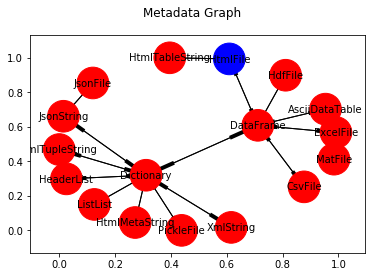

In [108]:
test_graph.show()

In [90]:
%timeit
# this is the result of the current get_path
test_graph.get_path('PickleFile',"Dictionary",debug=False)

['edge_PickleFile_Dictionary_000']

In [107]:
test_graph.move_to_node('HtmlFile')

In [52]:
first_node="ListList"
last_node="MatFile"
unvisited_nodes=test_graph.node_names[:]
unvisited_nodes.remove(first_node)
visited_nodes=[first_node]

In [37]:
print("{0} is {1}".format("unvisited_nodes",unvisited_nodes))
print("{0} is {1}".format("visited_nodes",visited_nodes))

unvisited_nodes is ['Dictionary', 'JsonString', 'JsonFile', 'XmlString', 'HtmlMetaString', 'XmlTupleString', 'PickleFile', 'HeaderList', 'DataFrame', 'AsciiDataTable', 'MatFile', 'ExcelFile', 'HdfFile', 'CsvFile', 'HtmlFile', 'HtmlTableString']
visited_nodes is ['ListList']


In [38]:
test_graph.get_exiting_nodes("ListList")

['Dictionary']

In [ ]:
def get_path(self,first_node,last_node,**options):
        """Returns the first path found between first node and last node, uses a breadth first search algorithm"""
        defaults={"debug":False,"method":"BreathFirst"}
        self.get_path_options={}
        for key,value in defaults.iteritems():
            self.get_path_options[key]=value
        for key,value in options.iteritems():
            self.get_path_options[key]=value
        unvisited_nodes=self.node_names[:]
        unvisited_nodes.remove(first_node)
        visited_nodes=[first_node]
        node_history=[]
        edge_history=[]
        path_queue=[]
        possible_paths=[]
        queue=[]
        queue.append(first_node)
        path={first_node:[]}
        while queue:
            # first remove the 
            current_node=queue.pop(0)    
            if path_queue!=[]:
                current_edge=path_queue.pop(0)
                edge_history.append(current_edge)
            node_history.append(current_node)
            if self.get_path_options["debug"]:
                print("current_node is {0}".format(current_node))
                print("current_edge is {0}".format(current_edge))
            # if this node is the destination exit returning the path
            if current_node==last_node:
                if self.get_path_options["debug"]:
                    print("Node path was found to be {0}".format(node_path))
                    print("path was found to be {0}".format(edge_path))
                    print("{0} is {1}".format("path",path))
                return path[last_node][::-1]

            adjacent_nodes=test_graph.get_exiting_nodes(current_node)
            adjacent_paths=test_graph.get_exiting_edges(current_node)
            if self.get_path_options["debug"]:
                print("{0} are {1}".format("adjacent_nodes",adjacent_nodes))
                print("{0} are {1}".format("adjacent_paths",adjacent_paths))
            current_history=edge_history
            for node_index,node in enumerate(adjacent_nodes):
                if node not in visited_nodes:
                    queue.append(node)
                    path_queue.append(adjacent_paths[node_index])
                    visited_nodes.append(node)
                    path[node]=[adjacent_paths[node_index]]+path[current_node]
                    path[node]
                    #possible_paths.append(current_path.append(node))
                    if self.get_path_options["debug"]:
                        print("{0} is {1}".format("path_queue",path_queue))
                


In [71]:
first_node="ListList"
last_node="MatFile"
unvisited_nodes=test_graph.node_names[:]
unvisited_nodes.remove(first_node)
visited_nodes=[first_node]
node_history=[]
edge_history=[]
path_queue=[]
possible_paths=[]
queue=[]
queue.append(first_node)
path={first_node:[]}
while queue:
    # first remove the 
    current_node=queue.pop(0)    
    if path_queue!=[]:
        current_edge=path_queue.pop(0)
        edge_history.append(current_edge)
    node_history.append(current_node)
    
    print("current_node is {0}".format(current_node))
    print("current_edge is {0}".format(current_edge))
    # if this node is the destination exit returning the path
    if current_node==last_node:
        print("Node path was found to be {0}".format(node_path))
        print("path was found to be {0}".format(edge_path))
        break
        
    adjacent_nodes=test_graph.get_exiting_nodes(current_node)
    adjacent_paths=test_graph.get_exiting_edges(current_node)
    print("{0} are {1}".format("adjacent_nodes",adjacent_nodes))
    print("{0} are {1}".format("adjacent_paths",adjacent_paths))
    current_history=edge_history
    for node_index,node in enumerate(adjacent_nodes):
        if node not in visited_nodes:
            queue.append(node)
            path_queue.append(adjacent_paths[node_index])
            visited_nodes.append(node)
            path[node]=[adjacent_paths[node_index]]+path[current_node]
            path[node]
            #possible_paths.append(current_path.append(node))
            print("{0} is {1}".format("path_queue",path_queue))
    

    

current_node is ListList
current_edge is edge_AsciiDataTable_MatFile_000
adjacent_nodes are ['Dictionary']
adjacent_paths are ['edge_ListList_Dictionary_000']
path_queue is ['edge_ListList_Dictionary_000']
current_node is Dictionary
current_edge is edge_ListList_Dictionary_000
adjacent_nodes are ['JsonString', 'XmlString', 'HtmlMetaString', 'XmlTupleString', 'PickleFile', 'ListList', 'HeaderList', 'DataFrame']
adjacent_paths are ['edge_Dictionary_JsonString_000', 'edge_Dictionary_XmlString_000', 'edge_Dictionary_HtmlMetaString_000', 'edge_Dictionary_XmlTupleString_000', 'edge_Dictionary_PickleFile_000', 'edge_Dictionary_ListList_000', 'edge_Dictionary_HeaderList_000', 'edge_Dictionary_DataFrame_000']
path_queue is ['edge_Dictionary_JsonString_000']
path_queue is ['edge_Dictionary_JsonString_000', 'edge_Dictionary_XmlString_000']
path_queue is ['edge_Dictionary_JsonString_000', 'edge_Dictionary_XmlString_000', 'edge_Dictionary_HtmlMetaString_000']
path_queue is ['edge_Dictionary_JsonStr

In [74]:
path[last_node][::-1]

['edge_ListList_Dictionary_000',
 'edge_Dictionary_DataFrame_000',
 'edge_DataFrame_AsciiDataTable_000',
 'edge_AsciiDataTable_MatFile_000']

In [ ]:
def get_path_breadth_first(graph_model,first_node,last_node):
    """Returns the first path found between first node and last node, five step paths are broken"""
    #todo: long paths are not found have to add a follow right hand side algorithm
    #Remove circular paths added 12/2016
    
    # incase we need the edge pattern
    edge_pattern=re.compile('edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)')
    # first get a copy of all the node names
    all_nodes=graph_model.node_names[:]
    unvisited_nodes=all_nodes.remove(first_node)
    visited_nodes=[first_node]
    exit_paths=graph_model.get_exiting_edges(first_node)
    next_nodes=graph_model.get_exiting_nodes(first_node)
    #be careful here using the wrong assignment statement breaks this function




